# Foreign Exchange Forecasting using LSTMs

In [10]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import keras
from keras.layers import Dropout, Bidirectional, CuDNNLSTM, Dense, Activation, LSTM

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [11]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = 'USD/IDR'

# USD-IDR

## Data Overview
From Google Finance

In [12]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df = pd.read_csv(url, parse_dates=['Date'])
df.drop('Unnamed: 2', axis=1, inplace=True)
df = df.sort_values('Date')
df.head()

,Date,Close
0,01/01/2020 23:58:00,13689.23
366,01/01/2021 23:58:00,14024.13
731,01/01/2022 23:58:00,14242.00
1096,01/01/2023 23:58:00,15538.50
31,01/02/2020 23:58:00,13762.30


Text(0, 0.5, 'Close Price (IDR)')

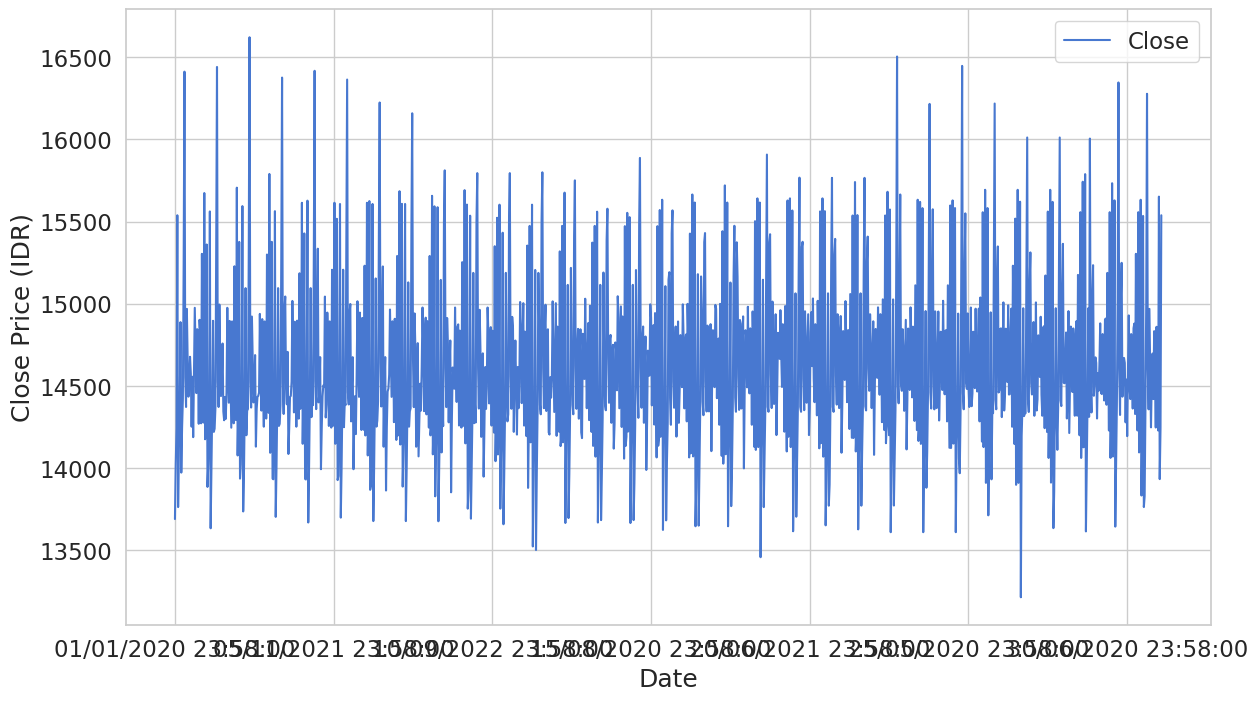

In [13]:
ax = df.plot(x='Date', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (IDR)")

## Data preprocessing

In [14]:
scaler = StandardScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1244, 1)

In [15]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

## Making sequences

In [16]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)

In [17]:
X_train.shape

(1029, 99, 1)

In [18]:
X_test.shape

(115, 99, 1)

## Building LSTM model

In [19]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()
model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  LSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=False)
))
model.add(Dense(units=1))
model.add(Activation('linear'))

2023-05-29 16:26:46.125626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 16:26:46.851408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 16:26:46.851783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 16:26:46.854014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 16:26:46.854215: I tensorflow/compile

## Training

In [187]:
BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    metrics=['mae'],
    optimizer='adam',
)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
15/15 [==============================] - 7s 113ms/step - loss: 0.9074 - mae: 0.7635 - val_loss: 1.0439 - val_mae: 0.8599
Epoch 2/50
15/15 [==============================] - 1s 55ms/step - loss: 0.8525 - mae: 0.7297 - val_loss: 0.6946 - val_mae: 0.6272
Epoch 3/50
15/15 [==============================] - 1s 56ms/step - loss: 0.8493 - mae: 0.7409 - val_loss: 0.7605 - val_mae: 0.7001
Epoch 4/50
15/15 [==============================] - 1s 56ms/step - loss: 0.7608 - mae: 0.6983 - val_loss: 0.5765 - val_mae: 0.5350
Epoch 5/50
15/15 [==============================] - 1s 56ms/step - loss: 0.7724 - mae: 0.6965 - val_loss: 0.6507 - val_mae: 0.6364
Epoch 6/50
15/15 [==============================] - 1s 59ms/step - loss: 0.7375 - mae: 0.6742 - val_loss: 0.6067 - val_mae: 0.6170
Epoch 7/50
15/15 [==============================] - 1s 63ms/step - loss: 0.7596 - mae: 0.6903 - val_loss: 0.5711 - val_mae: 0.5708
Epoch 8/50
15/15 [==============================] - 1s 65ms/step - loss: 0.6889 - 

In [188]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 39ms/step - loss: 0.9567 - mae: 0.6886


[0.9566720128059387, 0.6886018514633179]

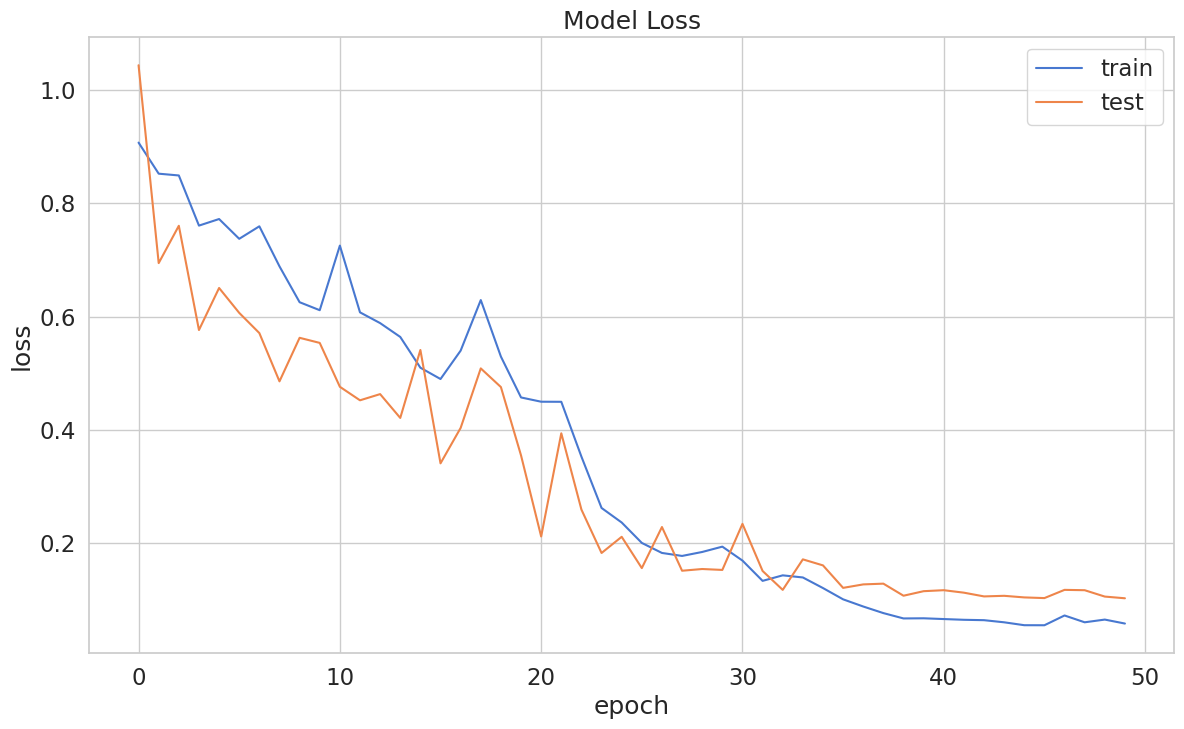

In [189]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Prediction

4/4 [==============================] - 0s 19ms/step


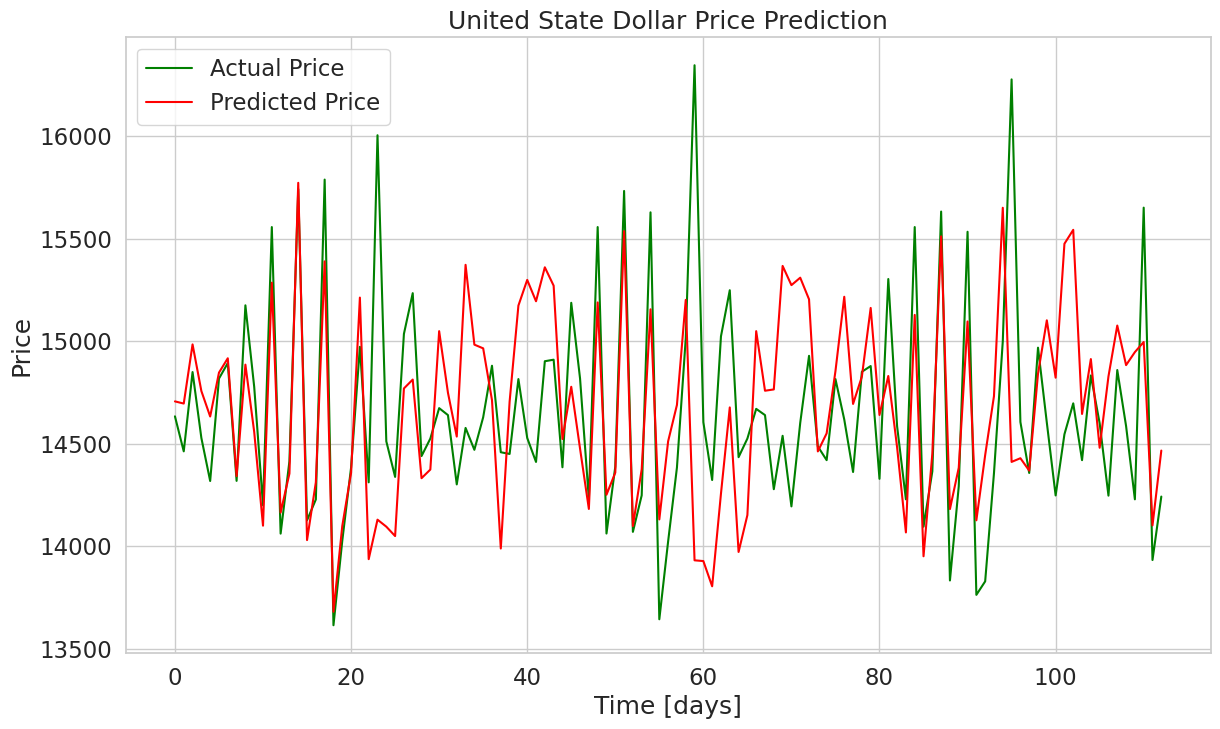

In [190]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('United State Dollar Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

# GA

In [32]:
import random
from deap import base, creator, tools

# Import the necessary libraries for LSTM model and dataset
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [33]:
# Step 1: Define the problem
# Assume we have a binary classification task with input X and output y
# Define X and y accordingly

# Step 2: Design the LSTM architecture
def create_lstm_model(units):
    model = Sequential()
    model.add(LSTM(units, input_shape=(WINDOW_SIZE, X_train.shape[-1])))
    model.add(Dense(1))
    return model

# Step 3: Define the chromosome representation
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("units", random.randint, 10, 100)  # Randomly select number of units for the LSTM layer
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.units, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/home/danielbudi/miniconda3/envs/tf/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [34]:
# Step 4: Define the fitness function
def evaluate_lstm(individual):
    units = individual[0]
    model = create_lstm_model(units)
    # Split the data into training and validation sets
    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    # Compile and train the LSTM model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    # Evaluate the model on the validation set
    y_pred = model.predict(X_test)
    fitness = mean_squared_error(y_test, y_pred)
    return fitness,

toolbox.register("evaluate", evaluate_lstm)

# Step 5: Initialize the population
population = toolbox.population(n=10)

In [35]:
# Step 10: Repeat steps 6-9 for a certain number of generations
num_generations = 5
for gen in range(num_generations):
    # Step 6: Evaluate the population
    fitnesses = map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Step 7: Selection
    offspring = toolbox.select(population, k=len(population))

    # Step 8: Genetic operators (Crossover and Mutation)
    offspring = list(map(toolbox.clone, offspring))
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.9:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.1:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Step 9: Generate the next generation
    population = offspring

2023-05-25 21:37:19.886119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:19.887572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:19.888701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 5ms/step


2023-05-25 21:37:24.495221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:24.496910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:24.497966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 4ms/step


2023-05-25 21:37:28.597484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:28.599460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:28.600708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step


2023-05-25 21:37:32.549433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:32.550961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:32.552128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step


2023-05-25 21:37:36.500652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:36.502387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:36.503327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 4ms/step


2023-05-25 21:37:40.625476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:40.627100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:40.628523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 4ms/step


2023-05-25 21:37:45.369821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:45.371758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:45.373204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 4ms/step


2023-05-25 21:37:50.159800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:50.161603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:50.162821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 5ms/step


2023-05-25 21:37:54.773281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:54.775008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:54.776076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 5ms/step


2023-05-25 21:37:59.668637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:37:59.670989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:37:59.672464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 4ms/step


2023-05-25 21:38:04.690243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 21:38:04.691690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 21:38:04.692649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

AttributeError: 'Toolbox' object has no attribute 'select'

In [ ]:
# Step 11: Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
best_units = best_individual[0]

In [ ]:
# Step 12: Train and evaluate the LSTM model with the best individual
best_model = create_lstm_model(best_units)
best_model.compile(optimizer='adam', loss='mean_squared_error')
best_model.fit(X, y, epochs=10, batch_size=32, verbose=0)

# Step 13: Fine-tuning (if required)

# Use the best_model for prediction or further evaluation